In [1]:
import matplotlib 
from matplotlib import pyplot as plt
import time

In [2]:
# Load MNIST data

import numpy as np
import gzip
import struct


def load_images(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Read the header information into a bunch of variables:
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(16))
        # Read all the pixels into a NumPy array of bytes:
        all_pixels = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the pixels into a matrix where each line is an image:
        return all_pixels.reshape(n_images, columns * rows)


# 60000 images, each 784 elements (28 * 28 pixels)
X_train = load_images("../data/mnist/train-images-idx3-ubyte.gz")

# 10000 images, each 784 elements, with the same structure as X_train
X_test = load_images("../data/mnist/t10k-images-idx3-ubyte.gz")


def load_labels(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Skip the header bytes:
        f.read(8)
        # Read all the labels into a list:
        all_labels = f.read()
        # Reshape the list of labels into a one-column matrix:
        return np.frombuffer(all_labels, dtype=np.uint8).reshape(-1, 1)


def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 10
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y


# !!! EDIT PATHS TO WHERE YOUR MNIST DATA IS !!!

# 60K labels, each a single digit from 0 to 9
Y_train_unencoded = load_labels("../data/mnist/train-labels-idx1-ubyte.gz")

# 60K labels, each consisting of 10 one-hot encoded elements
Y_train = one_hot_encode(Y_train_unencoded)

# 10000 labels, each a single digit from 0 to 9
Y_test = load_labels("../data/mnist/t10k-labels-idx1-ubyte.gz")

In [3]:
# A neural network implementation (almost the same as backpropagation.py,
# except for a tiny refactoring in the back() function).

import numpy as np


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def softmax(logits):
    exponentials = np.exp(logits)
    return exponentials / np.sum(exponentials, axis=1).reshape(-1, 1)


def sigmoid_gradient(sigmoid):
    return np.multiply(sigmoid, (1 - sigmoid))


def loss(Y, y_hat):
    return -np.sum(Y * np.log(y_hat)) / Y.shape[0]


def prepend_bias(X):
    return np.insert(X, 0, 1, axis=1)


def forward(X, w1, w2):
    h = sigmoid(np.matmul(prepend_bias(X), w1))
    y_hat = softmax(np.matmul(prepend_bias(h), w2))
    return (y_hat, h)


def back(X, Y, y_hat, w2, h):
    w2_gradient = np.matmul(prepend_bias(h).T, (y_hat - Y)) / X.shape[0]
    w1_gradient = np.matmul(prepend_bias(X).T, np.matmul(y_hat - Y, w2[1:].T) 
                            * sigmoid_gradient(h)) / X.shape[0]
    return (w1_gradient, w2_gradient)


def classify(X, w1, w2):
    y_hat, _ = forward(X, w1, w2)
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)


def initialize_weights(n_input_variables, n_hidden_nodes, n_classes):
    w1_rows = n_input_variables + 1
    w1 = np.random.randn(w1_rows, n_hidden_nodes) * np.sqrt(1 / w1_rows)

    w2_rows = n_hidden_nodes + 1
    w2 = np.random.randn(w2_rows, n_classes) * np.sqrt(1 / w2_rows)

    return (w1, w2)


def report(iteration, X_train, Y_train, X_test, Y_test, w1, w2):
    y_hat, _ = forward(X_train, w1, w2)
    training_loss = loss(Y_train, y_hat)
    classifications = classify(X_test, w1, w2)
    accuracy = np.average(classifications == Y_test) * 100.0
    print("Iteration: %5d, Loss: %.8f, Accuracy: %.2f%%" %
          (iteration, training_loss, accuracy))
    return accuracy, training_loss
    

def train(X_train, Y_train, X_test, Y_test, n_hidden_nodes, iterations, lr):
    start_time = time.time()
    success_rates = []
    losses = []
    times = []
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]
    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    for iteration in range(iterations):
        y_hat, h = forward(X_train, w1, w2)
        w1_gradient, w2_gradient = back(X_train, Y_train, y_hat, w2, h)
        w1 = w1 - (w1_gradient * lr)
        w2 = w2 - (w2_gradient * lr)
        accuracy, training_loss = report(iteration, X_train, Y_train, X_test, Y_test, w1, w2)
        success_rates.append(accuracy)
        losses.append(training_loss)
        times.append(time.time()-start_time)
    return (w1, w2, success_rates, losses, times)





In [ ]:
# three layers

def forward3(X, W1, W2, W3):
    H1 = sigmoid(np.matmul(prepend_bias(X), W1))
    H2 = sigmoid(np.matmul(prepend_bias(H1), W2))
    Y_hat = softmax(np.matmul(prepend_bias(H2), W3))
    return (Y_hat, H2, H1)

def back3(X, Y, Y_hat, W2, W3, H1, H2):
    W3_gradient = np.matmul(prepend_bias(H2).T, (Y_hat - Y)) / X.shape[0]
    W2_gradient = np.matmul(prepend_bias(H1).T, np.matmul( Y_hat - Y, W3[1:].T) 
                            * sigmoid_gradient(H2))  / X.shape[0]
    W1_gradient = np.matmul(prepend_bias( X).T, np.matmul( np.matmul( Y_hat - Y, W3[1:].T) 
                            * sigmoid_gradient(H2) , W2[1:].T) * sigmoid_gradient(H1)) / X.shape[0]
    return (W1_gradient, W2_gradient, W3_gradient)

def back4(X,Y, Y_hat, W2, W3, W4, H1, H2, H3):
    W4_gradient = np.matmul(prepend_bias(H3).T, (Y_hat - Y)) / X.shape[0]
    W3_gradient = np.matmul(prepend_bias(H2).T, np.matmul( Y_hat - Y, W4[1:].T) * sigmoid_gradient(H3)) / X.shape[0]
    W2_gradient = np.matmul(prepend_bias(H1).T, np.matmul( np.matmul(Y_hat - Y, W4[1:].T) * sigmoid_gradient(H3), W3[1:].T) * sigmoid_gradient(H2)) / X.shape[0]
    W1_gradient = np.matmul(prepend_bias(X ).T, np.matmul(np.matmul( np.matmul(Y_hat - Y, W4[1:].T) * sigmoid_gradient(H3), W3[1:].T) * sigmoid_gradient(H2), W2[1:].T) * sigmoid_gradient(H1)) / X.shape[0]

    return (W1_gradient, W2_gradient, W3_gradient, W4_gradient)

def classify3(X, W1, W2, W3):
    y_hat,_,_ = forward3(X, W1, W2, W3)
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)

def initialize_weights3(n_input_variables, h1, h2, n_classes):
    w1_rows = n_input_variables + 1
    w1 = np.random.randn(w1_rows, h1) * np.sqrt(1 / w1_rows)

    w2_rows = h1 + 1
    w2 = np.random.randn(w2_rows, h2) * np.sqrt(1 / w2_rows)

    w3_rows = h2 + 1
    w3 = np.random.randn(w3_rows, n_classes) * np.sqrt(1 / w2_rows)
    return (w1, w2, w3)

def report3(iteration, X_train, Y_train, X_test, Y_test, w1, w2, w3):
    y_hat,_,_ = forward3(X_train, w1, w2, w3)
    training_loss = loss(Y_train, y_hat)
    classifications = classify3(X_test, w1, w2, w3)
    accuracy = np.average(classifications == Y_test) * 100.0
    print("Iteration: %5d, Loss: %.8f, Accuracy: %.2f%%" %
          (iteration, training_loss, accuracy))
    return accuracy, training_loss

def train3(X_train, Y_train, X_test, Y_test, h1, h2, iterations, lr):
    start_time = time.time()
    success_rates = []
    losses = []
    times = []
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]
    w1, w2, w3 = initialize_weights3(n_input_variables, h1, h2, n_classes)
    for iteration in range(iterations):
        y_hat, H2, H1 = forward3(X_train, w1, w2, w3)
        w1_gradient, w2_gradient, w3_gradient = back3(X_train, Y_train, y_hat, w2, w3, H1, H2)
        w1 = w1 - (w1_gradient * lr)
        w2 = w2 - (w2_gradient * lr)
        w3 = w3 - (w3_gradient * lr)
        accuracy, training_loss = report3(iteration, X_train, Y_train, X_test, Y_test, w1, w2, w3)
        success_rates.append(accuracy)
        losses.append(training_loss)
        times.append(time.time()-start_time)
    return (w1, w2, w3, success_rates, losses, times)



In [6]:
# create a dictionary to store your success rates
# !!! UNCOMMENT, EXECUTE, AND COMMENT AGAIN !!!
# !!! DON'T EXECUTE THE LINES AGAIN AFTER STARTING TO COLLECT RESULTS !!!

#success_rates = {}
#losses = {}
#times = {}

In [12]:
n_train = 60000 # number of examples in training data (max is 60,000)
n_test  = 10000 # number of examples in training data (max is 10,000)
h1      = 200 # number of nodes in hidden layer 1
h2      = 200 # number of nodes in hidden layer 1
n_iters = 300 # number of iterations
lr      = 0.6
batchsize = 6000

lr_str = str(lr).replace('.', 'p')
name = 'success_rates_train{}_test{}_1h{}_2h{}_iters{}_lr{}_batchsize{}'.format(n_train, n_test, h1, h2, n_iters, lr_str, batchsize) 

(w1, w2, w3, sr, ls, ts) = train3(X_train[:n_train], Y_train[:n_train], 
                   X_test[:n_test], Y_test[:n_test], 
                   h1=h1, h2=h2, iterations=n_iters, lr=lr)
success_rates[name] = sr # store results
times[name] = ts
    

TypeError: back3() missing 2 required positional arguments: 'H2' and 'H3'

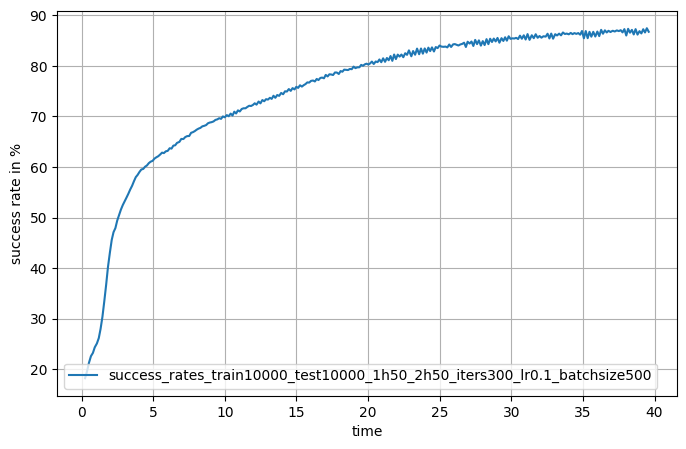

In [9]:
# plot results as a function of wall time
plt.figure(figsize = (8,5))
plt.plot(        times['success_rates_train10000_test10000_1h50_2h50_iters300_lr0p1_batchsize500'], 
         success_rates['success_rates_train10000_test10000_1h50_2h50_iters300_lr0p1_batchsize500'], 
               label = 'success_rates_train10000_test10000_1h50_2h50_iters300_lr0.1_batchsize500')

plt.legend()
plt.xlabel('time')
plt.ylabel('success rate in %')
plt.grid()
#plt.ylim([80,95]) # uncomment line to restrict the y-range for more detailed view on the late training
#plt.xlim([0,100]) # uncomment line to restrict the y-range for more detailed view on the late training